<a href="https://colab.research.google.com/github/Suemin-Lee/SPIB_kinetics/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Protein-Ligand kinetic using SPIB
##### This Colab demonstrates the calculation of residence time for the FKBP-DMSO protein-ligand complex. The given example is shown in the paper[link]. This code contains the condensed version compared to the original. To run the full version and accurate results, please consider changing the number of simulations as discussed in the paper.




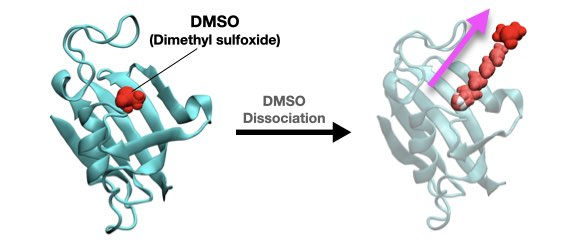



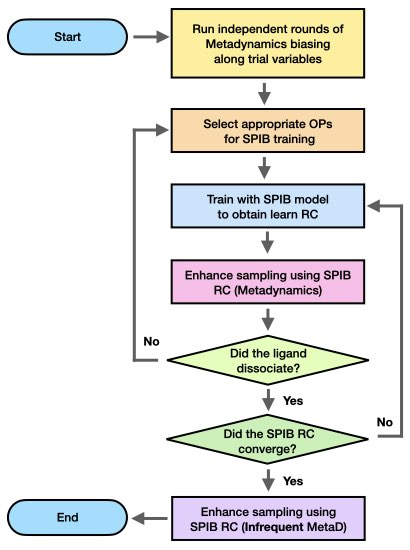

# 0. Installations

In [ ]:
#@title 0.1 Installation step1
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [ ]:
#@title 0.2 Installation step2 (<5min)

import time
t1 = time.perf_counter()
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge numpy matplotlib mdtraj openmm cudatoolkit=11.2 openmmforcefields openmm-plumed=1.0
    !conda install -q -y -c pytorch pytorch=1.11

    on_colab = True
    clear_output()             # clear the excessive installation outputs (disable incase of error check)
    print("Dependencies successfully installed and imported!")
except ModuleNotFoundError:
    on_colab = False

!pwd

# required for simulation with Plumed on gpu
from sys import stdout
from openmmplumed import PlumedForce
from openmm.app import *
from openmm import *
from openmm.unit import *

# required for analysis
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

t2 = time.perf_counter()
print('time taken to run:',t2-t1)

Dependencies successfully installed and imported!
/content


time taken to run: 224.02557311


#1. Trial Run (MetaD with trial variables- HBond)

In [ ]:
!git clone https://github.com/Suemin-Lee/SPIB_kinetics.git
%cd SPIB_kinetics

Cloning into 'SPIB_kinetics'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 354 (delta 92), reused 201 (delta 61), pack-reused 115
Receiving objects: 100% (354/354), 78.37 MiB | 21.41 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Updating files: 100% (57/57), done.
/content/SPIB_kinetics


In [ ]:
from FKBP_openmm.MDSimulation import MDSimulation
import time
from IPython.display import clear_output

### 1.1 Let's run our first simulations (~15min)

In [ ]:
#@title #####Simulation preparation (copy directories for individual simulation runs)
%%bash
for i in {2..4}; do
  cp -r simulation/initial_trial/initial_trial1 simulation/initial_trial/initial_trial$i
done

##### SIMULATION PARAMETERS + Plumed File Load

In [ ]:
simutlation_steps = 1000000 # 1000000*0.002 ps >> 2000ps = 2ns
plumed_file_name = 'plumed_initial.dat'
threshold_val = 2.2 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation = 4
dir_path = '/initial_trial'

#### RUN FIRST SET OF SIMULATION (MetaD with Trial Variables)

In [ ]:
#@title ###### Define simulation function
def run_simulation_round(i, simutlation_steps, plumed_file_name, threshold_val,dir_path):
    clear_output(wait=True)
    print('***** Currently Running %i round of simulation******' % i)
    sim_directory = dir_path+'%i' % i
    md_sim = MDSimulation(work_dir= '/simulation'+dir_path + sim_directory)

    with md_sim.working_directory():
        md_sim.remove_previous_old_files()  # if exist, delete old files

        # Simulation Set-Up
        simulation = md_sim.simulation_preperation(equilibration=False)
        positions = simulation.context.getState(getPositions=True).getPositions()

        print("Simulating...")
        md_sim.run_MD(simulation, positions, nsteps=simutlation_steps, report_steps=False, committor=True,
                      use_plumed=True, plumed_file=plumed_file_name, stride=500, threshold=threshold_val)

        md_sim.remove_last_line()
md_sim = MDSimulation()

In [ ]:
# Simulation
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 4 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
 
========== Committor Activated ==========
 
====== The Ligand has not dissociated yet ======
 
 
 ****  Current steps  =   10 ps / 2000 ps
       ligand location = 0.74      
 ****  Current steps  =   20 ps / 2000 ps
       ligand location = 0.66      
 ****  Current steps  =   30 ps / 2000 ps
       ligand location = 0.68      
 ****  Current steps  =   40 ps / 2000 ps
       ligand location = 0.70      
 ****  Current steps  =   50 ps / 2000 ps
       ligand location = 0.70      
 ****  Current steps  =   60 ps / 2000 ps
       ligand location = 0.65      
 ****  Current steps  =   70 ps / 2000 ps
       ligand location = 0.74      
 ****  Current steps  =   80 ps / 2000 ps
       ligand location = 0.72      
 ****  Current steps  =   90 ps / 2000 ps
       ligand location = 0.78      
 ****  Current steps  =   100 ps / 2000 ps
       ligand location = 0.93    

## 1.2 Select OPs for SPIB tranining from simulation trajectory

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import importlib.util
from sklearn.cluster import KMeans
from itertools import groupby
import sys
import os

In [ ]:
#@title ##### Load previous simulation data
orginal_path = os.path.abspath('.')

data_list=[]
data_list_str=[]

print('...Loading...')
for i in range(1,5):
    print('Simulation %i Trajectory'%(i))
    sim_path = '/simulation/initial_trial/initial_trial%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()

    locals()['metaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))

os.chdir(orginal_path)

...Loading...
Simulation 1 Trajectory
Simulation 2 Trajectory
Simulation 3 Trajectory
Simulation 4 Trajectory


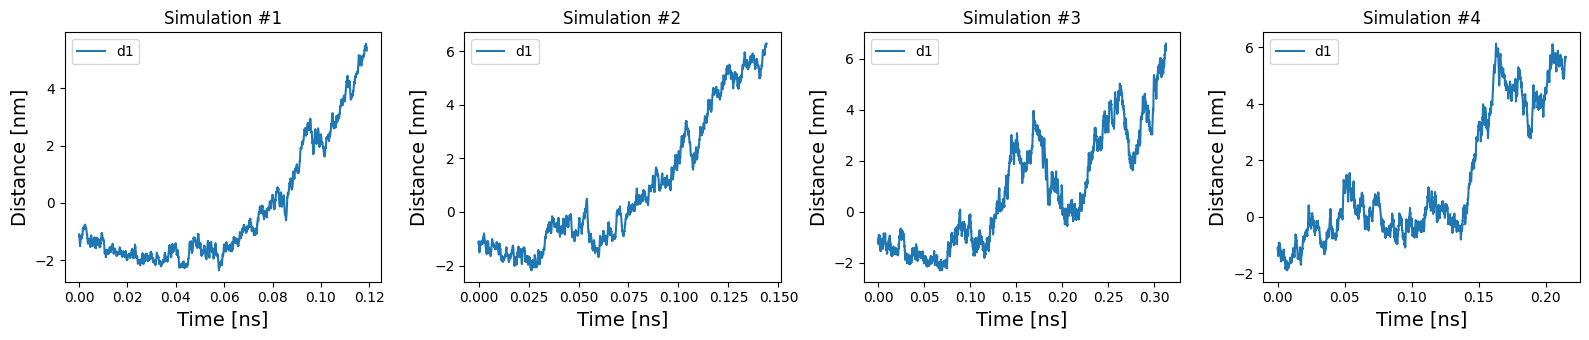

In [ ]:
#@title Visualize the data and also initiate K-mean Clustering +Labeling for SPIB

work_dir = '/SPIB_training/SPIB01'
os.chdir(orginal_path+work_dir)

plt.figure(figsize=(16,3.5))

for i, simulation_data in enumerate(data_list):
    # print(simulation_data.shape)

    distance = simulation_data[:,[0,-3]] # take time and the d1 (distance) column data
    bias = simulation_data[:,[-2,-1]]
    bias_distance = simulation_data[:,[0,-4]]
    traj_raw = simulation_data[:,[-3,-4]]

    time = (bias_distance[:,0]-500)/1000

    plt.subplot(1,4,i+1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
    plt.legend()
    plt.title('Simulation #%i'%(i+1))

    ######
    # One-hot encoded initial state assignment: Using K-mean clustering
    ######
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)

    distance_simulation_data = simulation_data[:,1:29]

    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

plt.tight_layout()
# Combine all SPIB output data files for all 4 trajectories
concatenate_data = np.concatenate(data_list, axis=0)[:,1:29]

concatenate_data_mean = np.mean(concatenate_data, axis=0)
concatenate_data_std = np.std(concatenate_data, axis=0)

np.save('data/FKBP_distance_data_mean.npy', concatenate_data_mean)
np.save('data/FKBP_distance_data_std.npy', concatenate_data_std)


## 1.3 Let's run our **1st** SPIB stage

In [ ]:
# run SPIB with the selected hyperparameters in the sample_config.ini files on here 4 trajectories
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini

Iteration 500:	Time 1.361509 s
Loss (train) 3.010454	KL loss (train): 2.973722
Reconstruction loss (train) 3.010157
Loss (test) 2.994150	KL loss (test): 2.722302
Reconstruction loss (test) 2.993878
tensor([0.0000, 0.0000, 0.0000, 0.5983, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1532, 0.2485, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.619400
Update lr to 0.000010
Epoch: 1

Iteration 1000:	Time 2.964488 s
Loss (train) 2.974176	KL loss (train): 3.074863
Reconstruction loss (train) 2.973868
Loss (test) 2.999527	KL loss (test): 2.865419
Reconstruction loss (test) 2.999240
tensor([0.0000, 0.0000, 0.0000, 0.6132, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2411, 0.1457, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.136058
Update lr to 0.000010
Epoch: 2

Iteration 1500:	Time 4.459024 s
Loss (train) 2.960045	KL loss (train): 3.477613
Reconstruction loss (tr

In [ ]:
%cd SPIB_training/SPIB01/
# !pwd

[Errno 2] No such file or directory: 'SPIB_training/SPIB01/'
/content/SPIB_kinetics


## 1.4 Generate Plumed file from learn RC for next MetaD simulation

In [ ]:
!python plumed_generator.py

===== First updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.2210374  0.23519655]


In [ ]:
#copy files to new simulation directory
!mv data/plumed_metaD_ANN.dat ../../simulation/01_metaD/01_metaD1
%cd ../../

/content/SPIB_kinetics


#2. Second simulation runs (MetaD with learned RC from SPIB stage 1)

2.1 Let's run our second simulations (~15min)

In [ ]:
#@title ##### Simulation preparation (copy directories for individual simulation runs)
%%bash
for i in {2..4}; do
    cp -r simulation/01_metaD/01_metaD1 simulation/01_metaD/01_metaD$i
done

In [ ]:
#@title ##### SIMULATION PARAMETERS + Plumed File Load
simutlation_steps = 500000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_metaD_ANN.dat'
threshold_val = 2.2 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation= 4
dir_path = '/01_metaD'

#### RUN SECOND SET OF SIMULATION (MetaD with learned RC from SPIB stage 1)

In [ ]:
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 4 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
 
========== Committor Activated ==========
 
====== The Ligand has not dissociated yet ======
 
 
 ****  Current steps  =   10 ps / 1000 ps
       ligand location = 0.96      
 ****  Current steps  =   20 ps / 1000 ps
       ligand location = 1.13      
 ****  Current steps  =   30 ps / 1000 ps
       ligand location = 0.91      
 ****  Current steps  =   40 ps / 1000 ps
       ligand location = 0.78      
 ****  Current steps  =   50 ps / 1000 ps
       ligand location = 1.32      
 ****  Current steps  =   60 ps / 1000 ps
       ligand location = 1.08      
 ****  Current steps  =   70 ps / 1000 ps
       ligand location = 1.08      
 ****  Current steps  =   80 ps / 1000 ps
       ligand location = 0.85      
 ****  Current steps  =   90 ps / 1000 ps
       ligand location = 0.84      
 ****  Current steps  =   100 ps / 1000 ps
       ligand location = 0.86    

In [ ]:
#@title #### Load previous simulation data

orginal_path = os.path.abspath('.')

data_list=[]
data_list_str=[]

print('...Loading...')
for i in range(1,5):
    print('Simulation %i Trajectory'%(i))
    sim_path = '/simulation/01_metaD/01_metaD%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()

    locals()['metaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))

os.chdir(orginal_path)

...Loading...
Simulation 1 Trajectory
Simulation 2 Trajectory
Simulation 3 Trajectory
Simulation 4 Trajectory


## 2.2 Select OPs for SPIB tranining from simulation trajectory

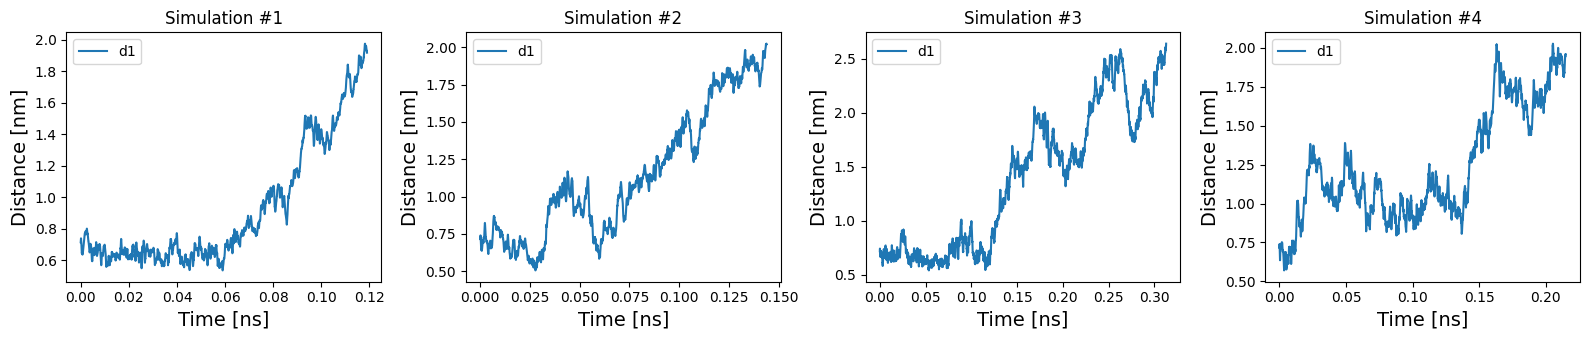

In [ ]:
#@title Visualize the data and also initiate K-mean Clustering +Labeling for SPIB

work_dir = '/SPIB_training/SPIB02'
os.chdir(orginal_path+work_dir)

# visualize the data
plt.figure(figsize=(16,3.5))
for i, simulation_data in enumerate(data_list):
    # print(simulation_data.shape)

    distance = simulation_data[:,[0,-5]] # take time and the 426th columns of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]]
    bias_distance = simulation_data[:,[0,-5]]
    traj_raw = simulation_data[:,[-4,-3]]

    time = (bias_distance[:,0]-500)/1000

    plt.subplot(1,4,i+1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
    plt.legend()
    plt.title('Simulation #%i'%(i+1))

#     #####
#     One-hot encoded initial state assignment: Using K-mean clustering
#     #####
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)

    distance_simulation_data = simulation_data[:,1:29]

    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

plt.tight_layout()

## 2.3 Let's run our **2nd** SPIB stage

In [ ]:
# run SPIB with the selected hyperparameters in the sample_config.ini files on here 4 trajectories
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


tensor([0.0000, 0.0000, 0.0000, 0.4753, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5247, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.674721
Update lr to 0.000010
Epoch: 1

tensor([0.0000, 0.0000, 0.0000, 0.4588, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5412, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.023342
Update lr to 0.000010
Epoch: 2

tensor([0.0000, 0.0000, 0.0000, 0.4473, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.5527, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.016224
Update lr to 0.000010
Epoch: 3

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4517e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.4386e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.5449e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.

In [ ]:
!pwd

/content/SPIB_kinetics/SPIB_training/SPIB02


## 2.4 Generate Plumed file from learn RC for next MetaD simulation


In [ ]:
%cd /content/SPIB_kinetics/SPIB_training/SPIB02

/content/SPIB_kinetics


In [ ]:
!python plumed_generator_v2.py

===== First updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.20317349 0.19009386]


In [ ]:
!cp data/plumed_metaD_ANN.dat ../../simulation/02_inMetaD/02_inMetaD1

In [ ]:
!pwd
%cd ../../

/content/SPIB_kinetics/SPIB_training/SPIB02
/content/SPIB_kinetics


# 3. Final infrequent metadynamics

### 3.1 Let's run our Final iMetaD simulations (up to ~60 min)

In [ ]:
#@title ##### Simulation preparation (copy directories for individual simulation runs)
%%bash
for i in {2..6}; do
    cp -r simulation/02_inMetaD/02_inMetaD1 simulation/02_inMetaD/02_inMetaD$i
done

In [ ]:
#@title ##### SIMULATION PARAMETERS + Plumed File Load
simutlation_steps = 2000000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_metaD_ANN.dat'
threshold_val = 2.2 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation= 6
dir_path = '/02_inMetaD'

#### RUN FINAL SET OF SIMULATION (iMetaD with learned RC from SPIB stage 2)

In [ ]:
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 6 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
 
========== Committor Activated ==========
 
====== The Ligand has not dissociated yet ======
 
 
 ****  Current steps  =   10 ps / 4000 ps
       ligand location = 0.68      
 ****  Current steps  =   20 ps / 4000 ps
       ligand location = 0.68      
 ****  Current steps  =   30 ps / 4000 ps
       ligand location = 0.86      
 ****  Current steps  =   40 ps / 4000 ps
       ligand location = 0.76      
 ****  Current steps  =   50 ps / 4000 ps
       ligand location = 0.75      
 ****  Current steps  =   60 ps / 4000 ps
       ligand location = 0.77      
 ****  Current steps  =   70 ps / 4000 ps
       ligand location = 0.76      
 ****  Current steps  =   80 ps / 4000 ps
       ligand location = 0.75      
 ****  Current steps  =   90 ps / 4000 ps
       ligand location = 0.72      
 ****  Current steps  =   100 ps / 4000 ps
       ligand location = 0.85    

In [ ]:
#@title #### Load previous simulation data

orginal_path = os.path.abspath('.')

data_list_2=[]
data_list_str_2=[]

print('...Loading...')
for i in range(1,7):
    print('Simulation %i Trajectory'%(i))
    sim_path = '/simulation/02_inMetaD/02_inMetaD%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()
    # remove_line_change_rows()

    locals()['inMetaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list_2.append(locals()['inMetaD{0}'.format(i)])
    data_list_str_2.append('inMetaD{0}'.format(i))

os.chdir(orginal_path)

...Loading...
Simulation 1 Trajectory
Simulation 2 Trajectory
Simulation 3 Trajectory
Simulation 4 Trajectory
Simulation 5 Trajectory
Simulation 6 Trajectory


## 4. Let's calculate residence time and do curve fit

In [ ]:
#@title ### 4.1 Calculate residence time

residence_t_data = []

# Loop over the data points in 'data_list'
for i in range(len(data_list_2)):
    simulation_data = data_list_2[i]
    # Extract the time and bias columns from the simulation data
    time = simulation_data[:,0]
    bias = simulation_data[:,-2]
    # Calculate the time step (dt)
    dt = (time[-1]-time[-2])*1e-12
    k_B = 8.314462
    T = 300
    kbT = k_B*T/1000

    # Calculate the acceleration factor
    acceleration = np.exp(bias/kbT)
    residence_t = acceleration*dt
    residence_t = np.sum(residence_t)
    # Add the calculated residence time to the list of residence time data
    residence_t_data.append(residence_t)

print('Calculated Residence times are ...')
for resT in residence_t_data:
    T = resT*10**9
    print(f'Residence T = {T:4.2f} ns')

np.save('residence_t_data.npy',residence_t_data)

Calculated Residence times are ...
Residence T = 12.67 ns
Residence T = 5.44 ns
Residence T = 1.94 ns
Residence T = 19.79 ns
Residence T = 1.82 ns
Residence T = 52.31 ns


### 4.2 Curve Fit

Now all the simulations + SPIB is DONE!
Moving on to our final steps of curve fit

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import expon
from scipy import stats



In [ ]:
#@title ### Curve fit util functions
residence_t_data_extra = np.load('simulation/residence_t_extra.npy')

def include_extra_data(residence_t_data,residence_t_data_extra, num_sample=4):
    random_values = np.random.choice(residence_t_data_extra, size=num_sample, replace=False)
    return np.concatenate((np.array(residence_t_data), random_values))

def fit_function(k, lamb):
    return expon.cdf(k, scale=lamb)  # scale parameter is the 1/lambda (rate parameter)

def calculate_fitted_tau(residence_t_data, residence_t_data_extra, num_sample=6):
    # Randomly choose values from previously generated data that give p-value>0.05

    p_val = 0.0  # Initialize p_val to ensure the while loop starts

    while p_val <= 0.05:
        # Including extra data
        data = include_extra_data(residence_t_data, residence_t_data_extra, num_sample)

        if len(data) < 7:
            raise ValueError("The total number of data set is too small. Include more samples")

        # Preparing data for fitting
        x_min, x_max = np.min(data), np.max(data)
        log_bin = np.logspace(np.log10(x_min), np.log10(x_max), 100)
        count, bins_count = np.histogram(data, bins=log_bin)
        bin_centers = 0.5 * (bins_count[1:] + bins_count[:-1])

        pdf = count / sum(count)
        cdf = np.cumsum(pdf)

        # Fitting the curve
        parameters, cov_matrix = curve_fit(fit_function, bin_centers, cdf)

        # Performing KS test
        ks_test = stats.kstest(data,expon.cdf,(0, parameters))
        p_val = ks_test[1]  # Update p_val based on the latest KS test


    return p_val, parameters[0], bin_centers, cdf


Residence time = 18.00 ns
p-value = 0.6810


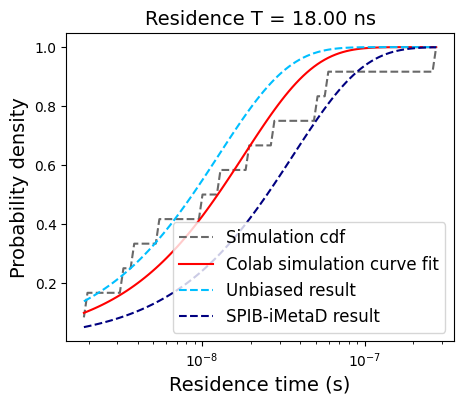

In [ ]:
num_sample = 6

p_val, parameters, bin_centers, cdf = calculate_fitted_tau(residence_t_data, residence_t_data_extra, num_sample)
print(f'Residence time = {parameters*10**9:2.2f} ns')
print(f'p-value = {p_val:.4f}')

plt.figure(figsize=(5,4))
plt.plot(bin_centers, cdf,'--',label='Simulation cdf',color="dimgray")
plt.xlabel(r'Residence time (s)',fontsize=14)
plt.ylabel('Probability density',fontsize=14)


fit_results = fit_function(bin_centers, parameters)
plt.plot(bin_centers,fit_results,label='Colab simulation curve fit',color="red")

# Unbiased result
unbiased = 12.59 *10**-9
unbiased_y = fit_function(bin_centers, unbiased)
plt.plot(bin_centers,unbiased_y,'--',label='Unbiased result',color="deepskyblue")

# SPIB-iMetaD result
SPIB_metaD = 36.22 *10**-9
SPIB_metaD_y = fit_function(bin_centers, SPIB_metaD)
plt.plot(bin_centers,SPIB_metaD_y,'--',label='SPIB-iMetaD result',color="navy")

plt.xscale('log')
plt.legend(fontsize = 12)
residenceT = parameters*10**9
plt.title(r'Residence T = %3.2f ns'%residenceT,fontsize = 14);




# Load xtc files to see the dissociation